# Predicting Tax Valuation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

import os
import env, acquire, prepare, features

## Visualizing Tax Rate Distribution
We begin by using our `acquire_cache_tax_data()` function to create a dataframe consisting of the tax rate for every record of interest. We are limiting our records to only those that meet the following requirements:
- Transaction Date between 2017-05-01 and 2017-06-30
- Property classified as one of the following Types:
    - Single Family Residential
    - Rural Residence
    - Mobile Home
    - Townhouse
    - Condominium
    - Row House
    - Bungalow
    - Manufactured, Modular, Prefabricated Homes
    - Patio Home
    - Inferred Single Family Residence

Tax rate is determined by the following formula:

    Tax Paid / Tax Value * 100 (rounded to 2 digits)

In [2]:
tax = acquire.acquire_cache_tax_data()

In [3]:
tax.head()

,taxrate,County
0,1.70,Los Angeles
1,1.53,Los Angeles
2,1.12,Orange
3,1.25,Los Angeles
4,1.19,Los Angeles


We split the dataframe into smaller ones representing each county

In [4]:
los_angeles_taxrate = tax[tax.County == 'Los Angeles'].taxrate
orange_taxrate = tax[tax.County == 'Orange'].taxrate
ventura_taxrate = tax[tax.County == 'Ventura'].taxrate

An initial histogram shows the following:
- The majority of the records are in Los Angeles county
- There is significant positive skew present in at least one of the counties, demonstrated by the large x-axis range
- The majority of the tax rates fall below 5%

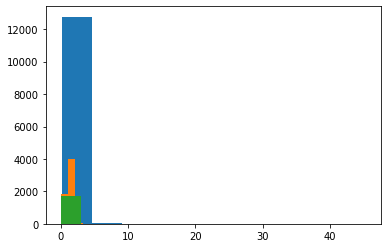

In [5]:
plt.hist(los_angeles_taxrate)
plt.hist(orange_taxrate)
plt.hist(ventura_taxrate)
plt.show()

Descriptive statistics of each county support our visual analysis. 

In [6]:
print(los_angeles_taxrate.describe())
print('\n')
print(orange_taxrate.describe())
print('\n')
print(ventura_taxrate.describe())

count    12807.000000
mean         1.380155
std          0.672991
min          0.110000
25%          1.210000
50%          1.250000
75%          1.390000
max         45.290000
Name: taxrate, dtype: float64


count    5845.000000
mean        1.205100
std         0.292402
min         0.010000
25%         1.050000
50%         1.150000
75%         1.260000
max        10.740000
Name: taxrate, dtype: float64


count    1711.000000
mean        1.212215
std         0.743119
min         0.080000
25%         1.070000
50%         1.120000
75%         1.190000
max        29.490000
Name: taxrate, dtype: float64


We create more meaningful visualizations of the distribution in each county
- Increase the number of bins
- Trim the x-axis to focus only on the region with the vast majority of observations
- Visualizing the mean and median for each region

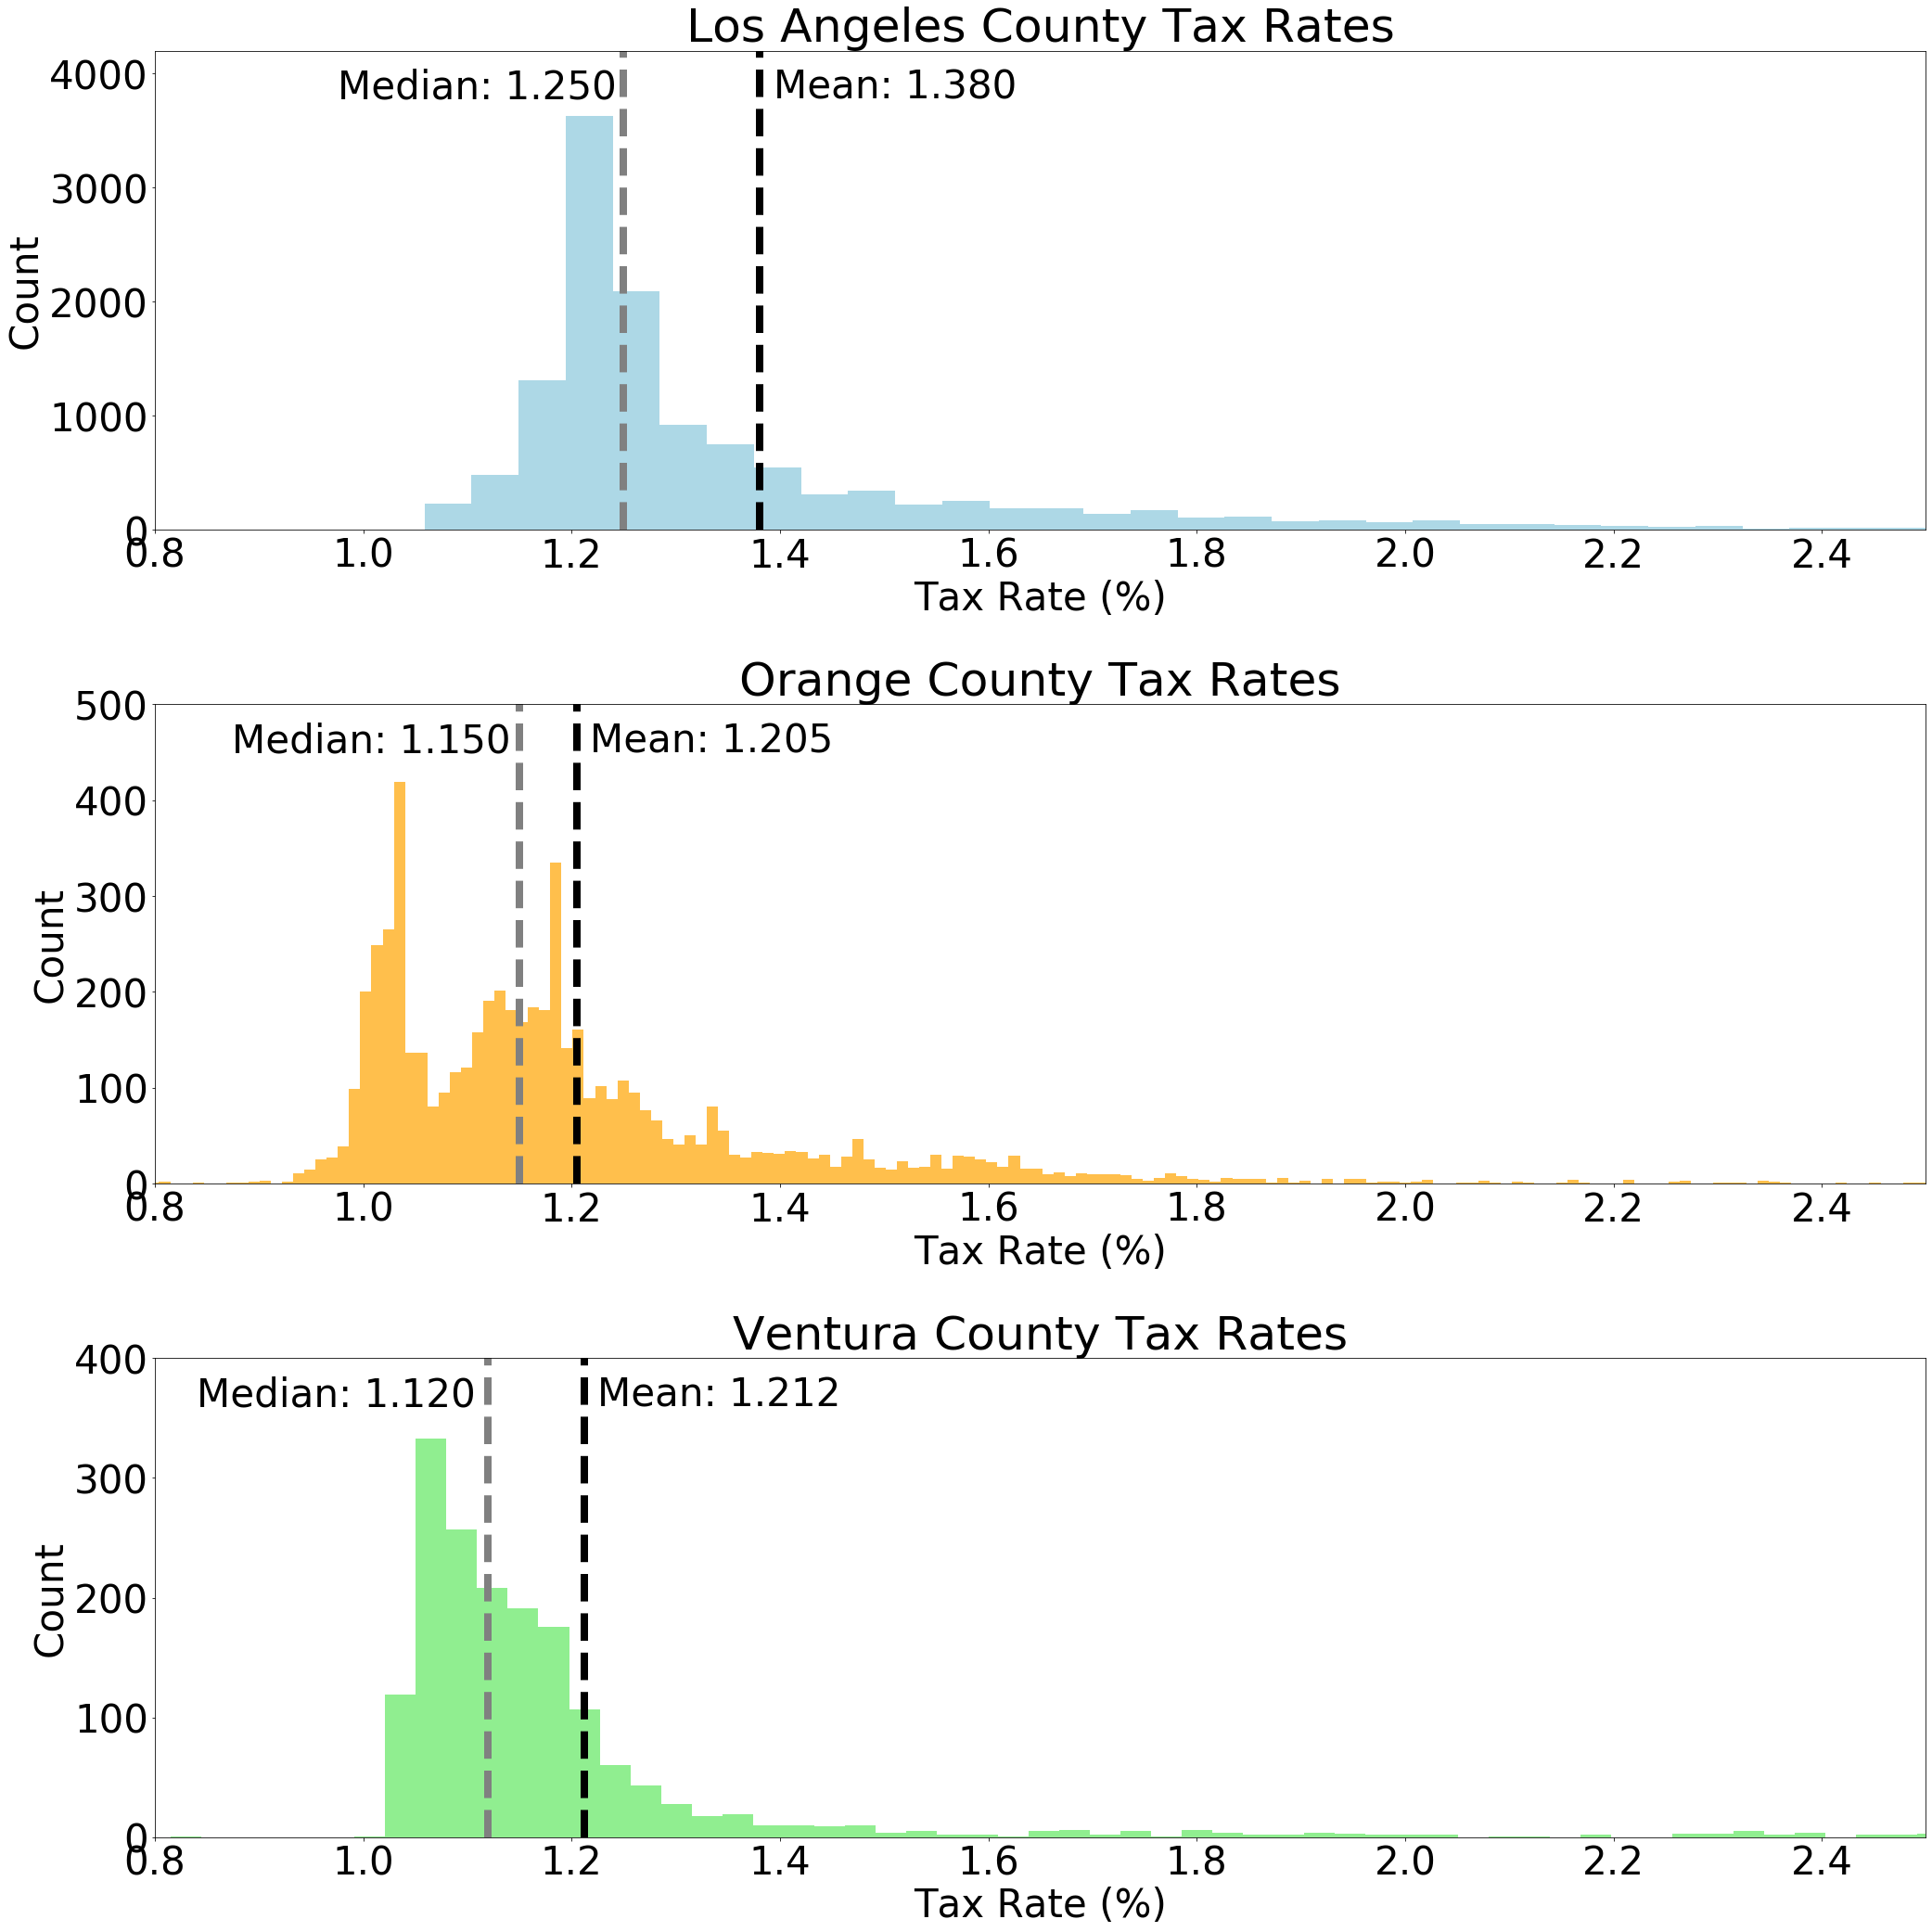

In [7]:
plt.rcParams.update({'font.size': 42}) # Sets global characteristics for font size

plt.figure(figsize=(30,30))
plt.subplot(3,1,1) # 
plt.hist(los_angeles_taxrate, bins = 1000, color = 'lightblue')
plt.xlim(0.8, 2.5) # Cropping range of x-axis
plt.ylim(0, 4200)
plt.title('Los Angeles County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate (%)')
min_ylim, max_ylim = plt.ylim()
plt.axvline(los_angeles_taxrate.mean(), color='k', linestyle='dashed', linewidth=8) # Creating visualization line for mean tax rate
plt.text(los_angeles_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(los_angeles_taxrate.mean())) # Creating annotation for mean tax rate line
plt.axvline(los_angeles_taxrate.median(), color='gray', linestyle='dashed', linewidth=8) # Creating visualization line for median tax rate
plt.text(los_angeles_taxrate.median()*.78, max_ylim*0.9, 'Median: {:.3f}'.format(los_angeles_taxrate.median())) # Creating annotation for median tax rate line 

plt.subplot(3,1,2)
plt.hist(orange_taxrate, bins = 1000, color = 'orange', alpha = 0.7)
plt.xlim(0.8, 2.5)
plt.ylim(0, 500)
plt.title('Orange County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate (%)')
min_ylim, max_ylim = plt.ylim()
plt.axvline(orange_taxrate.mean(), color='k', linestyle='dashed', linewidth=8)
plt.text(orange_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(orange_taxrate.mean()))
plt.axvline(orange_taxrate.median(), color='gray', linestyle='dashed', linewidth=8)
plt.text(orange_taxrate.median()*.76, max_ylim*0.9, 'Median: {:.3f}'.format(orange_taxrate.median()))

plt.subplot(3,1,3)
plt.hist(ventura_taxrate, bins = 1000, color = 'lightgreen')
plt.xlim(0.8, 2.5)
plt.ylim(0, 400)
plt.title('Ventura County Tax Rates')
plt.ylabel('Count')
plt.xlabel('Tax Rate (%)')
min_ylim, max_ylim = plt.ylim()
plt.axvline(ventura_taxrate.mean(), color='k', linestyle='dashed', linewidth=8)
plt.text(ventura_taxrate.mean()*1.01, max_ylim*0.9, 'Mean: {:.3f}'.format(ventura_taxrate.mean()))
plt.axvline(ventura_taxrate.median(), color='gray', linestyle='dashed', linewidth=8)
plt.text(ventura_taxrate.median()*.75, max_ylim*0.9, 'Median: {:.3f}'.format(ventura_taxrate.median()))

plt.tight_layout() # Reduces overlap of labels
# Uncomment the line below to save a .png of the visualization
# plt.savefig('county_tax_rates')
plt.show()

### Key Takeaways
- Mean tax rate is about 15% higher in Los Angeles county than in Orange or Venutra counties
- Orange county has the least positive skew, demonstrated by the smallest difference between the median and mean
- Los Angeles county has the most positive skew, demonstrated by the larger difference between the median and mean
- Given the large range of tax rates, most tax rates fall between 1 and 2 percent

## Data Acquisition for Model
Our initial model consists of three features:
- `calculatedfinishedsquarefeet`
- `bathroomcnt`
- `bedroomcnt`

And one target variable:
- `taxvaluedollarcnt`

In [8]:
df = acquire.acquire_cache_data()
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


## Data Preparation
We begin by summarizing the data using the following functions:
- `df.info()`
- `df.describe()`
- `df.dtypes()`

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20318 non-null  float64
 1   bathroomcnt                   20364 non-null  float64
 2   bedroomcnt                    20364 non-null  float64
 3   taxvaluedollarcnt             20364 non-null  float64
dtypes: float64(4)
memory usage: 636.5 KB


In [10]:
df.describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20318.000000,20364.000000,20364.000000,2.036400e+04
mean,1776.493208,2.284694,3.019839,5.054039e+05
std,936.606498,0.958072,1.030974,6.584038e+05
min,242.000000,0.000000,0.000000,1.050400e+04
25%,1176.000000,2.000000,2.000000,2.104808e+05
50%,1536.000000,2.000000,3.000000,3.665045e+05
75%,2102.000000,3.000000,4.000000,5.890250e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


In [11]:
df.dtypes

calculatedfinishedsquarefeet    float64
bathroomcnt                     float64
bedroomcnt                      float64
taxvaluedollarcnt               float64
dtype: object

### Address Missing Values
- There are 46 null values in the `calculatedfinishedsquarefeet` feature
- There are 70 observations with `bathroomcnt` equal to 0
- There are 136 observations with `bedroomcnt` equal to 0 

In [12]:
df.calculatedfinishedsquarefeet.isnull().sum()

46

In [13]:
df[df.bathroomcnt == 0].shape

(70, 4)

In [14]:
df[df.bedroomcnt == 0].shape

(136, 4)

#### We will drop all observations with 0 or NaN values

In [15]:
mask_bathr = (df.bathroomcnt == 0) # Creates a boolean mask of True where bathroom count == 0
mask_bedr = (df.bedroomcnt == 0) # Creates a boolean mask of True where bedroom count == 0
mask_sf = df.calculatedfinishedsquarefeet.isnull() # Creates a boolean mask of True where there is a null value

mask = mask_bathr | mask_bedr | mask_sf # Creates a boolean mask based on any of the individual masks being true (| is an OR operator)
mask.sum()

df = df[-mask] # Creates a dataframe for all values that are not True in the boolean mask
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20223 entries, 0 to 20363
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20223 non-null  float64
 1   bathroomcnt                   20223 non-null  float64
 2   bedroomcnt                    20223 non-null  float64
 3   taxvaluedollarcnt             20223 non-null  float64
dtypes: float64(4)
memory usage: 790.0 KB


In [16]:
# Double check to make sure the code removed all the missing values.

bathr_missing = df[df.bathroomcnt == 0].shape[0]
bedr_missing = df[df.bedroomcnt == 0].shape[0]
sf_missing = df.calculatedfinishedsquarefeet.isnull().sum()

bathr_missing, bedr_missing, sf_missing

(0, 0, 0)

### Address Duplicates
- There are 58 duplicated observations
- These duplicates may be from "back-to-back" closing between three parties on the same transaction date. These additional observations are not meaningful and will add noise to our model. 
- We will drop these duplicates. 

In [17]:
df.duplicated().sum()

58

In [18]:
df = df.drop_duplicates(keep='first', ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


In [19]:
df.describe()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
count,20165.000000,20165.000000,20165.000000,2.016500e+04
mean,1780.902108,2.297595,3.041706,5.047822e+05
std,932.715302,0.948802,0.999601,6.554203e+05
min,242.000000,1.000000,1.000000,1.050400e+04
25%,1179.000000,2.000000,2.000000,2.107920e+05
50%,1540.000000,2.000000,3.000000,3.674520e+05
75%,2107.000000,3.000000,4.000000,5.900000e+05
max,15450.000000,11.000000,12.000000,2.385837e+07


## Visualization of Variables

#### Looking at the target variable
- Similar to the tax rate distributions explored earlier, the tax valuations are clustered below a median of $367,452 and are positively skewed by large valuations to the right

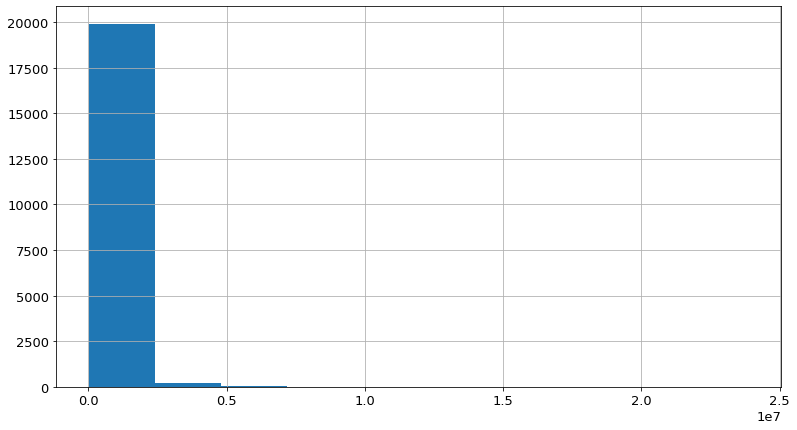

In [20]:
plt.rc('font',size=13)
plt.rc('figure', figsize=(13,7))

# Plot the distribution of the target variable: taxvaluedollarcnt

df.taxvaluedollarcnt.hist()

#### Looking at a pairplot of our variables

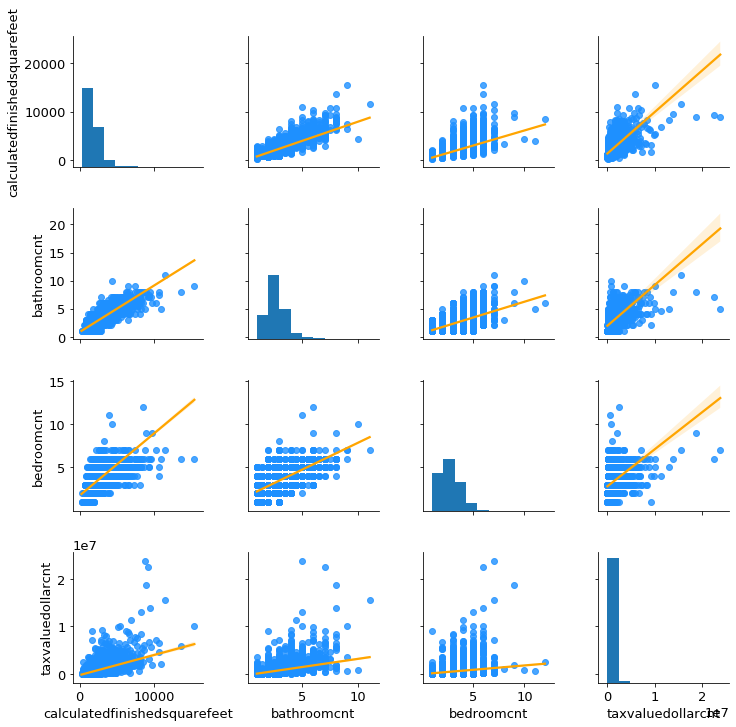

In [21]:
g = sns.PairGrid(df)
# we can specify any two functions we want for visualization
g.map_diag(plt.hist) # single variable
g.map_offdiag(sns.regplot, scatter_kws={"color": "dodgerblue"}, line_kws={"color": "orange"}) # interaction of two variables

#### Takeaways:
- There appears to be a positive correlation between all variables (risk for multicollinearity in our model)
- Distribution of all variables appears to be positively skewed
- Outliers in the `taxvaluedollarcnt` tend to sit above the regression lines for the independent variables rather than below. 

#### Looking at a box-plot of our variables

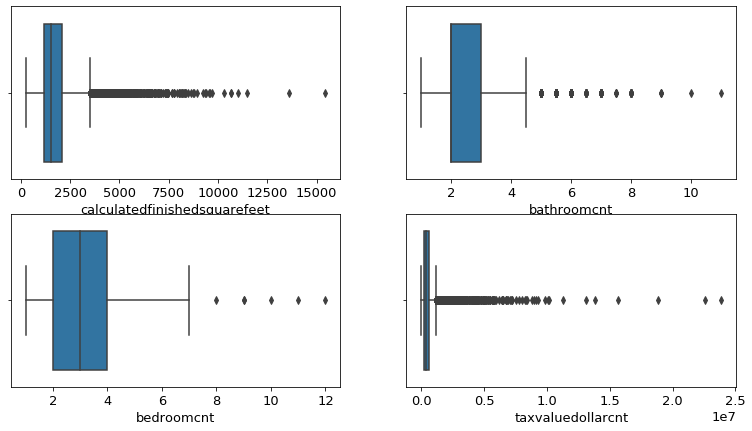

In [22]:
plt.subplot(221)
sns.boxplot(df.calculatedfinishedsquarefeet)

plt.subplot(222)
sns.boxplot(df.bathroomcnt)

plt.subplot(223)
sns.boxplot(df.bedroomcnt)

plt.subplot(224)
sns.boxplot(df.taxvaluedollarcnt)

#### Takeaways:
- For both `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` both show a large number of observations above the interquartile range. 

### Splitting and Scaling The Data
- We will use our `prep_zillow()` function to split and scale the data
- `prep_zillow()` will divide the dataframe in to train, validate and test dataframes
- It will then fit a min-max scaler to the train dataframe, and apply that scaler to all three dataframes

In [23]:
df.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
0,1458.0,2.0,3.0,136104.0
1,1421.0,1.0,2.0,35606.0
2,2541.0,3.0,4.0,880456.0
3,1650.0,2.0,3.0,614000.0
4,693.0,1.0,2.0,274237.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20165 entries, 0 to 20164
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  20165 non-null  float64
 1   bathroomcnt                   20165 non-null  float64
 2   bedroomcnt                    20165 non-null  float64
 3   taxvaluedollarcnt             20165 non-null  float64
dtypes: float64(4)
memory usage: 630.3 KB


In [25]:
train_scaled, validate_scaled, test_scaled = prepare.prep_zillow(df) #prep_zillow() function
train_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
16476,0.114492,0.111111,0.222222,0.017615
17919,0.126276,0.111111,0.222222,0.009729
3622,0.124049,0.111111,0.222222,0.006993
16863,0.112822,0.166667,0.111111,0.009475
15808,0.194470,0.222222,0.333333,0.012272


In [26]:
validate_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
13876,0.261459,0.388889,0.333333,0.020078
6471,0.134348,0.111111,0.333333,0.028051
8096,0.072370,0.055556,0.222222,0.020477
95,0.358415,0.333333,0.555556,0.017081
4969,0.132214,0.111111,0.111111,0.039345


In [27]:
test_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt
18614,0.147152,0.222222,0.333333,0.038559
17346,0.047783,0.000000,0.111111,0.003003
7558,0.096957,0.166667,0.222222,0.011701
8780,0.142605,0.111111,0.222222,0.029557
8940,0.121451,0.111111,0.222222,0.016871


## Modeling
- MVP:
    - X: `'calculatedfinishedsquarefeet'`, `'bathroomcnt'`, `'bedroomcnt'`
    - y:  `taxvaluedollarcnt`

In [28]:
# Create X and y

X_train_scaled = train_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']]
y_train_scaled = train_scaled['taxvaluedollarcnt']

### Setting up a Baseline

In [29]:
mean, median = train_scaled.taxvaluedollarcnt.agg(['mean', 'median'])
mean, median 

(0.021679118375542906, 0.015692126737139968)

In [30]:
# Create an array of baseline predictions using mean

baseline = np.array([mean]*train_scaled.shape[0])
baseline[:5], len(baseline)

(array([0.02167912, 0.02167912, 0.02167912, 0.02167912, 0.02167912]), 14518)

In [31]:
# Compute baseline sse

baseline_residual = y_train_scaled - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

11.533542707108785

In [32]:
# Compute baseline mse

baseline_mse = baseline_sse/train_scaled.shape[0]
baseline_mse

0.0007944305487745409

In [33]:
# Compute baseline rmse

baseline_rmse = mean_squared_error(y_train_scaled, baseline)**1/2
baseline_rmse

0.00039721527438727047

Note: These error values are small in magnitude because the target variable has been scaled by a min-max scaler. We will also use a scaled target when evaluating our model, so the relative difference in the error between the model and the baseline will still be preserved. 

## Compare 3 Different Algorithms for MVP
- LinearRegression
- LassoLars
- PolynomialFeatures + LinearRegression (2nd degree)

### Linear Regression

In [34]:
# Create, fit, predict and calculate the lm_rmse

lm = LinearRegression(normalize=True)
lm.fit(X_train_scaled, y_train_scaled)
lm_pred = lm.predict(X_train_scaled)
lm_rmse = mean_squared_error(y_train_scaled, lm_pred)**1/2

lm_rmse

0.00024919734598661327

In [35]:
# Does the model outperform baseline?
lm_rmse < baseline_rmse

True

### LassoLars

In [36]:
# Create, fit, predict and calculate the lars_rmse

lars = LassoLars(alpha=0.1)
lars.fit(X_train_scaled, y_train_scaled)
lars_pred = lars.predict(X_train_scaled)
lars_rmse = mean_squared_error(y_train_scaled, lars_pred)**1/2

lars_rmse

0.0003972152743872705

In [37]:
# Does the model outperform baseline?
lars_rmse < baseline_rmse

False

### PolynomialFeatures + LinearRegression
2nd degress polynomial

In [38]:
pf = PolynomialFeatures(degree=2)
X_train_scaled_squared = pf.fit_transform(X_train_scaled)

lm_squared = LinearRegression()
lm_squared.fit(X_train_scaled_squared, y_train_scaled)
lm_squared_pred = lm_squared.predict(X_train_scaled_squared)

lm_squared_rmse = mean_squared_error(y_train_scaled, lm_squared_pred)**1/2
lm_squared_rmse

0.00023320393387132827

In [39]:
# Does the model outperform baseline?
lm_squared_rmse < baseline_rmse

True

#### Takeaways:
- LinearRegression and LinearRegression with Polynomial Features outperform LassoLars
- LassoLars does not outperform our baseline

### Validate top 2 algorithms for MVP
- LinearRegression
- PolynomialFeatures + LinearRegression (2nd degree)

In [40]:
# Create X and y

X_validate_scaled = validate_scaled[['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt']]
y_validate_scaled = validate_scaled['taxvaluedollarcnt']

In [41]:
X_validate_scaled.head()

,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt
13876,0.261459,0.388889,0.333333
6471,0.134348,0.111111,0.333333
8096,0.072370,0.055556,0.222222
95,0.358415,0.333333,0.555556
4969,0.132214,0.111111,0.111111


In [42]:
y_validate_scaled.head()

13876    0.020078
6471     0.028051
8096     0.020477
95       0.017081
4969     0.039345
Name: taxvaluedollarcnt, dtype: float64

### Validation of LinearRegression

In [43]:
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [44]:
lm_pred = lm.predict(X_validate_scaled)
lm_rmse = mean_squared_error(y_validate_scaled, lm_pred)**1/2

lm_rmse

0.000344478679726347

#### Takeaway:
- When the model is used on validate, the overall error increases, but it is still below the error of the baseline on train

### Validation of LinearRegression + Polynomial Features

In [45]:
pf

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [46]:
X_validate_scaled_squared = pf.transform(X_validate_scaled)
lm_squared_pred = lm_squared.predict(X_validate_scaled_squared)

lm_squared_rmse = mean_squared_error(y_validate_scaled, lm_squared_pred)**1/2
lm_squared_rmse

0.00030490635693139126

#### Takeaway:
- When the model is used on validate, the overall error increases, but it is still below the error of the baseline on train
- This model is still outperforming our Linear Regression model

## Feature Engineering
Now that we have our MVP developed, we spend time looking at additional features available in the dataset. Evaluation of these features may warrant the development of a new model.

In [47]:
df2 = acquire.get_zillow_data('2')
df2.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
1,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
2,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,NaN,NaN,6.059064e+13,2028,0.021085,2017-06-01
3,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,NaN,NaN,6.037703e+13,3273,-0.325393,2017-06-01
4,11967869,2093710,NaN,NaN,NaN,1.0,2.0,NaN,5.0,1.0,...,274237.0,2016.0,191821.0,3267.47,NaN,NaN,6.037185e+13,3429,-0.005566,2017-06-29


Several columns have a large number of null values. We can evaluate the percentage of null values in each column.

In [48]:
# Compute the percentage of null values for each column. 

cols = df2.columns.tolist()
percentages = []
n_rows = df2.shape[0]

for col in cols:
    percentage = df2[col].isnull().sum()/n_rows
    percentages.append(percentage)
    
null_percentage = pd.DataFrame(percentages, index = cols)
null_percentage

,0
parcelid,0.000000
id,0.000000
airconditioningtypeid,0.680515
architecturalstyletypeid,0.997594
basementsqft,0.999460
...,...
taxdelinquencyyear,0.967344
censustractandblock,0.003781
id.1,0.000000
logerror,0.000000


We have set the limit for null values to 20%. Any column that is greater or equal to 20% null values will be dropped.

In [49]:
# Select all the cols that have less than 20% of null values

mask = null_percentage[0] < 0.2
null_percentage[mask].index.tolist()

['parcelid',
 'id',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'id.1',
 'logerror',
 'transactiondate']

We now have a collection of features that we can evaluate further for inclusion in an additional model.

In [50]:
# Selected features

# All of the features
features_target = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
                   'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode',
                   'rawcensustractandblock', 'regionidcity', 'regionidcounty','regionidzip',
                   'yearbuilt', 'censustractandblock', 'logerror', 'taxvaluedollarcnt']

# Only the independent variables
features = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
            'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode',
            'rawcensustractandblock', 'regionidcity', 'regionidcounty','regionidzip',
            'yearbuilt', 'censustractandblock', 'logerror']

# Only the dependent variable
target = ['taxvaluedollarcnt']

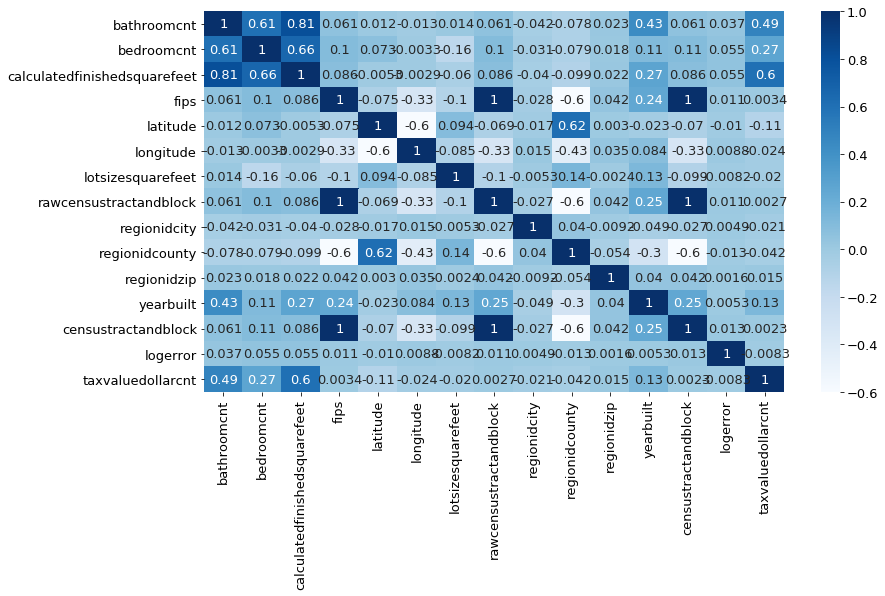

In [51]:
# corr_heatmap

df_vis = df2[features_target]
df_vis.head()

corr = df_vis.corr()
sns.heatmap(corr, cmap='Blues', annot=True)

#### Takeaways:
- The three features we used in our first model (`bathroomcnt`, `bedroomcnt`, `calculatedfinishedsquarefeet`) have the highest linear correlation with `taxvaluedollarcnt`
- Year build has a slight positive linear correlation with `taxvaluedollarcnt`
- As expected, there is a high degree of linear correlation between `bathroomcnt`, `bedroomcnt`, and `calculatedfinishedsquarefeet`
- There is also a perfect linear correlation between several variables. These variables are just different ways of describing the same characteristic. 
- Most of the regional data does not seem to have much of a linear correlation with `taxvaluedollarcnt`, but there still might be enough of a relationship there to improve the model by including these features. We will evaluate this further. 

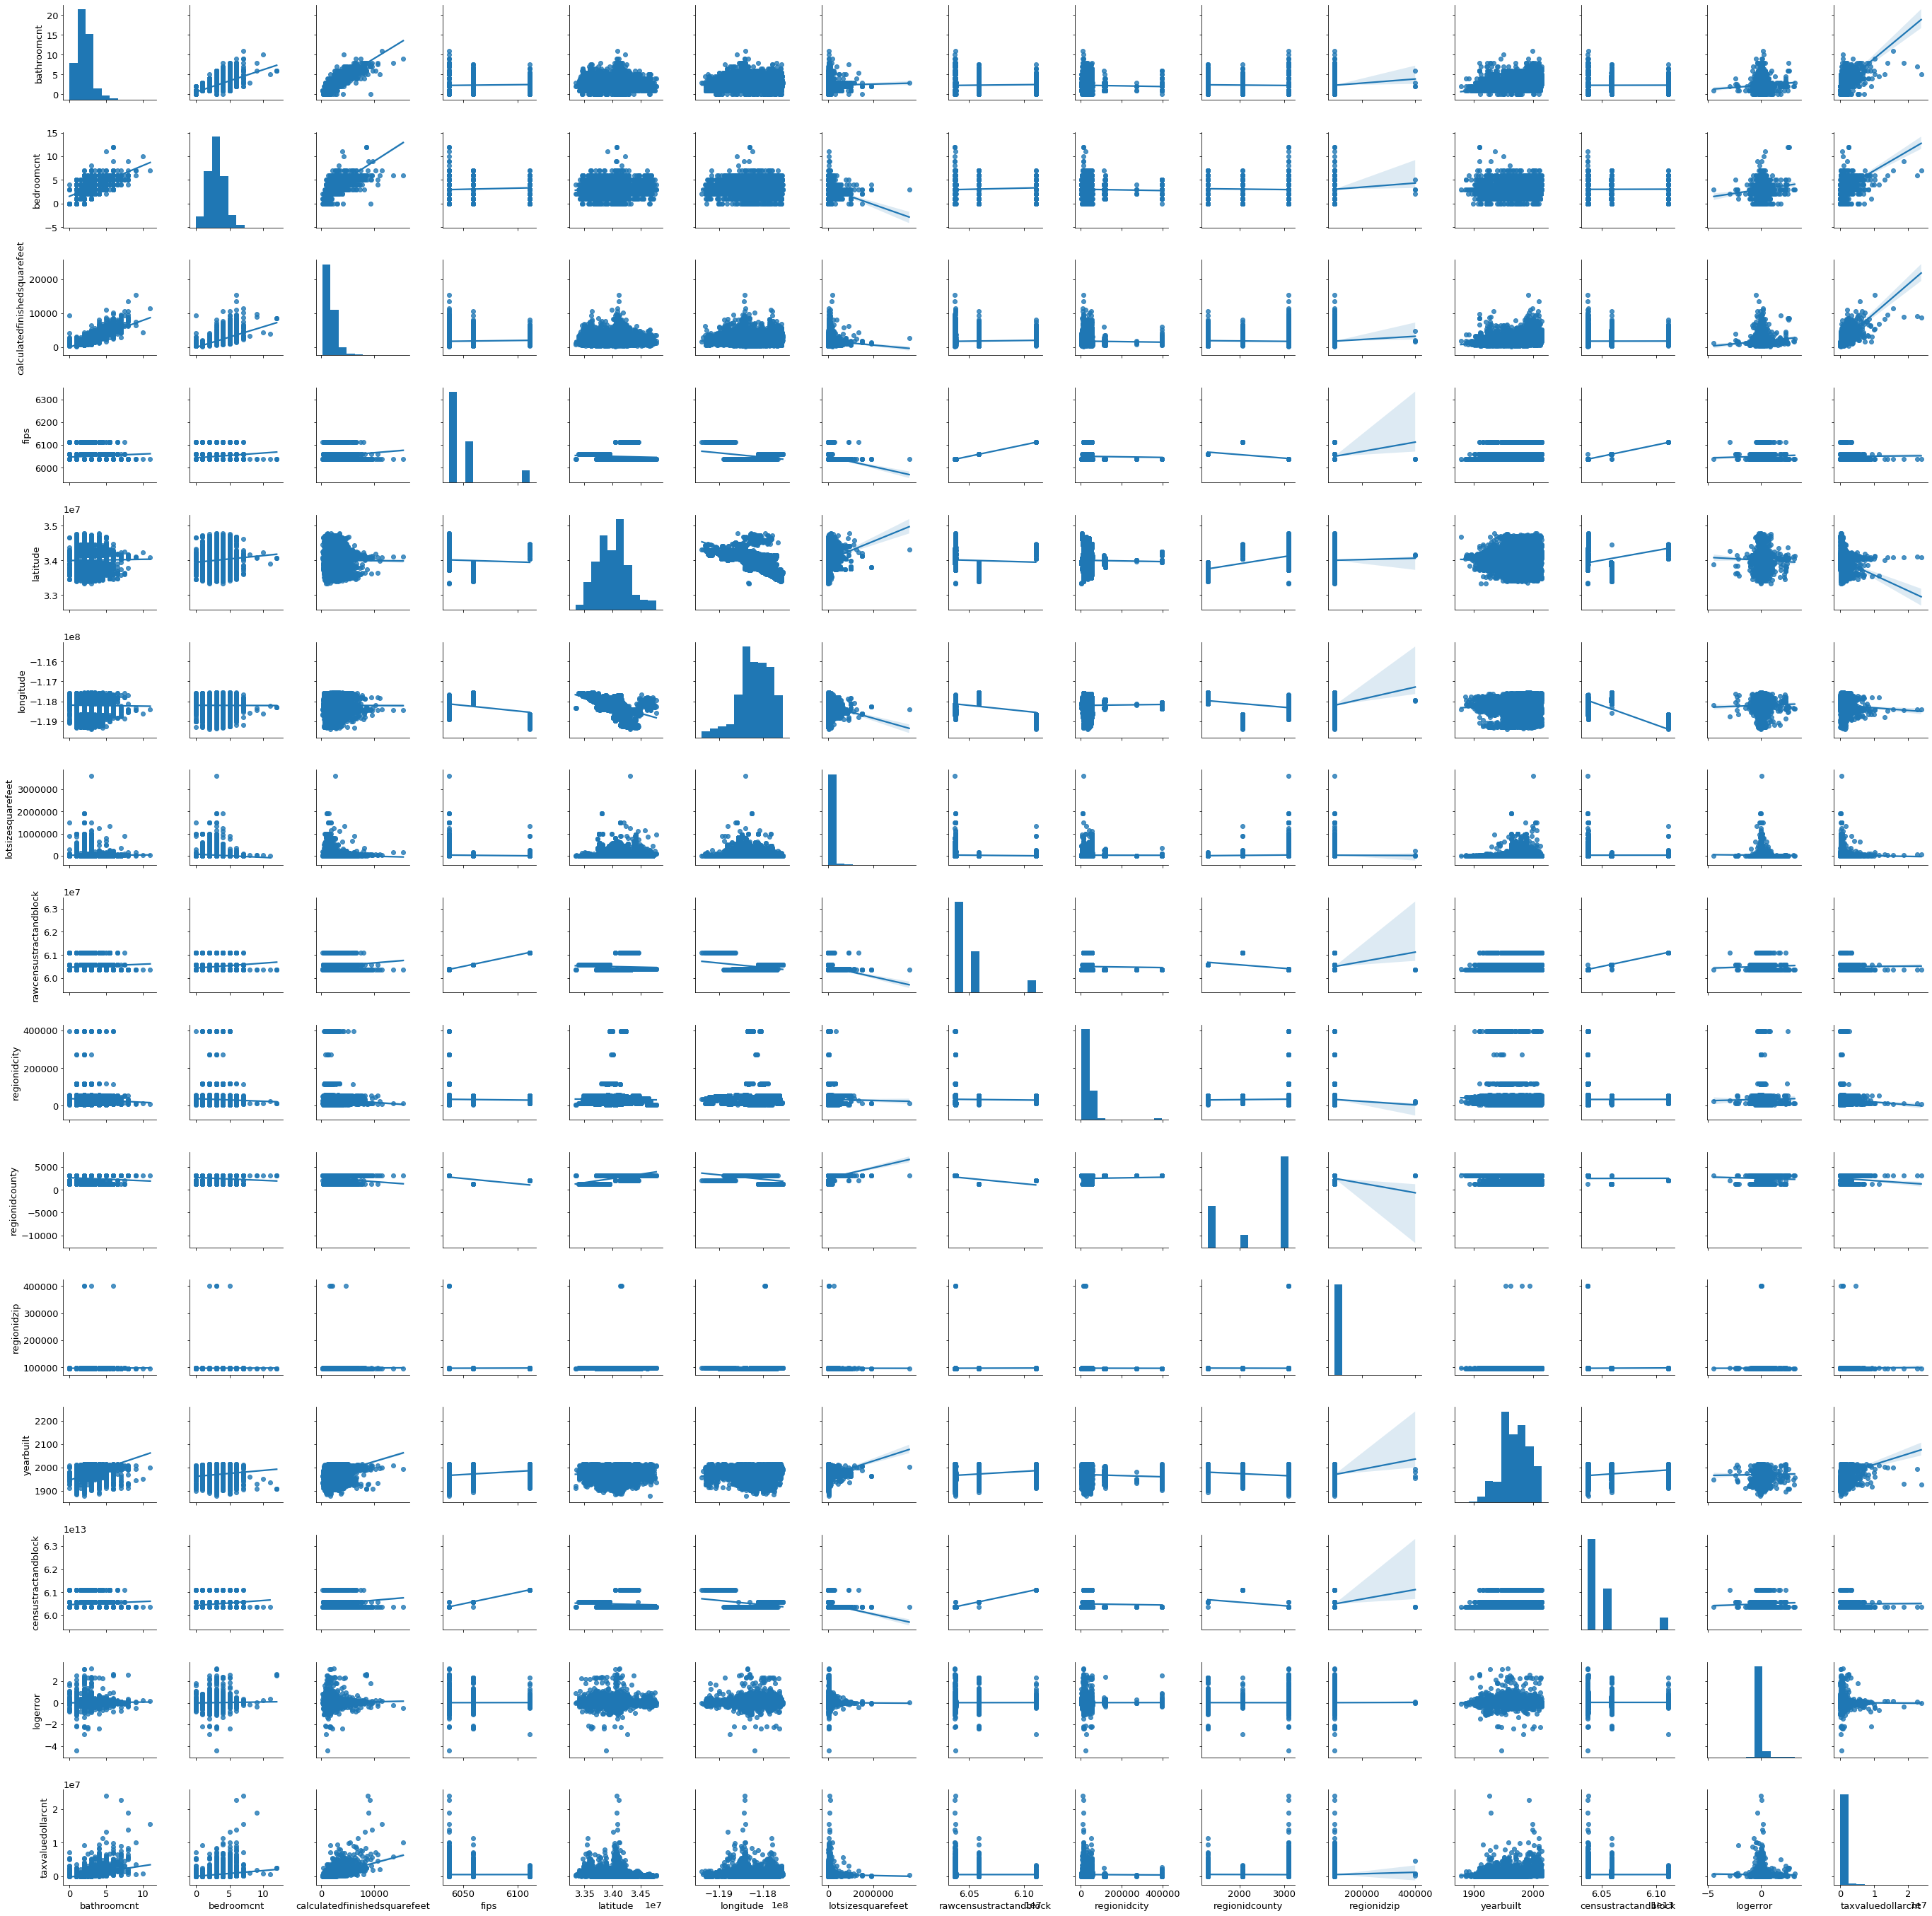

In [52]:
sns.pairplot(df_vis, kind='reg')

#### Takeaways:
While the correlation plot only checked for linear correlations, we can still see some patterns in the pairplot that may warrant the use of key variables in models:
- Outliers for tax value tend to fall above the line of best fit rather than below
- Not all fips codes are equal. We saw this in the intial visualization of tax distribution. Los Angeles County has a greater range than 
- lorem ipsum lorem ipsum lorem ipsum